In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binom_test
import scipy.stats

from statsmodels.graphics.tsaplots import plot_acf      # import ACF plot
from statsmodels.graphics.tsaplots import plot_pacf     # import PACF plot
from statsmodels.stats.diagnostic import acorr_ljungbox # import Ljung-Box Test
from statsmodels.tsa.arima_process import arma_generate_sample  # simulate ARMA process

from pmdarima.arima import auto_arima

In [2]:
def tsdiag(arimaResiduals, afcFags=50, lbLags = 10, figsize=(15, 15), style='bmh'):
    
    if not isinstance(arimaResiduals, pd.Series):
        arimaFittedvVlues = pd.Series(arimaResiduals)
        
   
    plt.figure(figsize=figsize) # Set the size of the figure

    layout = (4, 1)
    sr_ax = plt.subplot2grid(layout, (0, 0))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (2, 0))
    lb_ax = plt.subplot2grid(layout, (3, 0))

    # Create the standard residual plot
    sr_ax.plot(arimaFittedvVlues)
    sr_ax.set_title("Standardized Residuals")
    sr_ax.set_xlabel("Time")
    
    #compute acf and pacf
    acf = sm.tsa.acf(arimaResiduals, nlags=50)
    pacf = sm.tsa.pacf(arimaResiduals, nlags=50)
    interval_noise = 2/np.sqrt(arimaResiduals.size)

    # Crate the ACF plot
#     plot_acf(arimaResiduals, lags=afcFags, ax=acf_ax)
    acf_ax.stem(acf,linefmt='k',markerfmt='o', basefmt='k--')
    acf_ax.fill_between(lags[:lag_max+1],interval_noise, -interval_noise, color='lightblue', alpha=0.6)
    acf_ax.set_title('Auto-correlation function')
    acf_ax.legend(['95% confidence interval for noise'])

    #Create the PACF plot
#     plot_pacf(arimaResiduals, lags=afcFags, ax=pacf_ax)
    pacf_ax.stem(pacf,linefmt='k',markerfmt='o', basefmt='k--')
    pacf_ax.fill_between(lags[:lag_max+1],interval_noise, -interval_noise, color='lightblue', alpha=0.6)
    pacf_ax.legend(['95% confidence interval for noise'])
    pacf_ax.set_title('Partial auto-correlation function')

    # Create the Ljung-Box statitics plot
    lb = acorr_ljungbox(arimaResiduals, lags = lbLags)
    lbPvalue = lb[1] # get the pvalue from the ljungbox test

    lb_ax.scatter(np.arange(lbLags), lbPvalue,  facecolors='none', edgecolors='b')
    lb_ax.set_ylim(-0.1, 1)
    lb_ax.axhline(y=0.05, linestyle ='--')
    lb_ax.set_title("p values for Ljung-Box Statistic")
    lb_ax.set_ylabel("p values")
    lb_ax.set_xlabel("lags")


    plt.tight_layout()
    return

In [3]:
def qqplot(data):
    sm.qqplot(data, fit=True,line='45')

In [4]:
def sign_test(data):
    lag1 = data[:-1]
    data = data[1:]
    sign_changes = sum((lag1*data)<0)
    return sign_changes, binom_test(sign_changes, data.size, 1/2)

In [5]:
data_df = pd.read_csv('A3_co2.txt', sep=' ')
data_df.head()

,year,month,time,co2
0,1958,3,1958.208,315.71
1,1958,4,1958.292,317.45
2,1958,5,1958.375,317.50
3,1958,6,1958.458,317.10
4,1958,7,1958.542,315.86


In [6]:
co2_all = data_df['co2'].values
time_all = data_df['time'].values
co2_train = data_df['co2'].values[:-20]
time_train = data_df['time'].values[:-20]
co2_test = data_df['co2'].values[-20:]
time_test = data_df['time'].values[-20:]

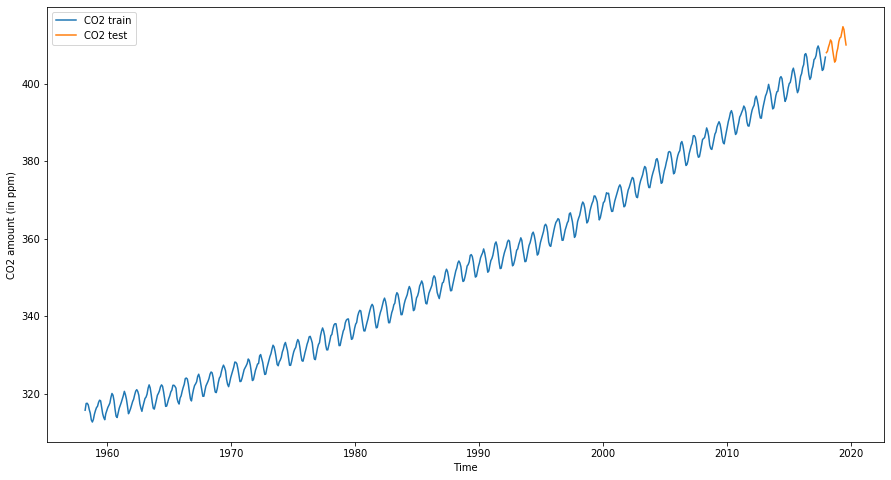

In [7]:
plt.figure(figsize=(15,8))
plt.plot(time_train, co2_train)
plt.plot(time_test, co2_test)
plt.legend(['CO2 train', 'CO2 test'], loc=2)
plt.ylabel('CO2 amount (in ppm)')
plt.xlabel('Time')
plt.show()

In [8]:
acf = sm.tsa.acf(co2_train, nlags=50)
pacf = sm.tsa.pacf(co2_train, nlags=50)
interval_noise = 1/2/np.sqrt(co2_train.size)
lags = np.arange(0,718)
lag_max = 50

In [9]:
def plot_cfs(data, return_is=False, nlags=50):    
    acf = sm.tsa.acf(data, nlags=nlags)
    pacf = sm.tsa.pacf(data, nlags=nlags)
    interval_noise = 2/np.sqrt(data.size)
    lags = np.arange(0,718)
    lag_max = nlags
    plt.figure(figsize=(16,11))
    plt.subplot(2,1,1)
    plt.stem(acf,linefmt='k',markerfmt='o', basefmt='k--')
    plt.fill_between(lags[:lag_max+1],interval_noise, -interval_noise, color='lightblue', alpha=0.6)
    plt.title('Auto-correlation function')
    plt.legend(['95% confidence interval for noise'])

    plt.subplot(2,1,2)
    plt.stem(pacf,linefmt='k',markerfmt='o', basefmt='k--')
    plt.fill_between(lags[:lag_max+1],interval_noise, -interval_noise, color='lightblue', alpha=0.6)
    plt.legend(['95% confidence interval for noise'])
    plt.title('Partial auto-correlation function')
    plt.show()
    if return_is:
        return acf, pacf

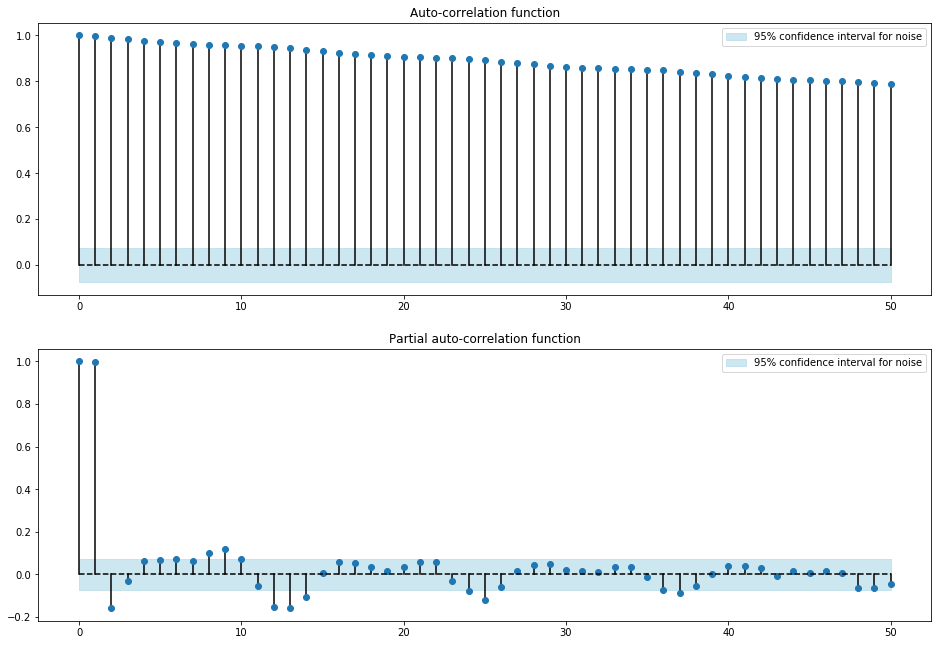

In [10]:
plot_cfs(co2_train)

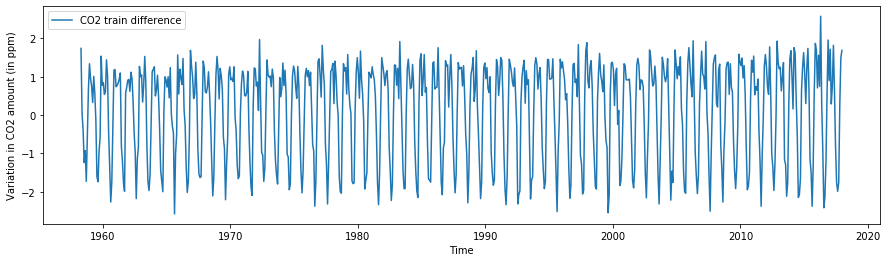

In [11]:
plt.figure(figsize=(15,4))
plt.plot(time_train[1:], co2_train[1:]-co2_train[:-1])
plt.legend(['CO2 train difference'], loc=2)
plt.ylabel('Variation in CO2 amount (in ppm)')
plt.xlabel('Time')
plt.show()

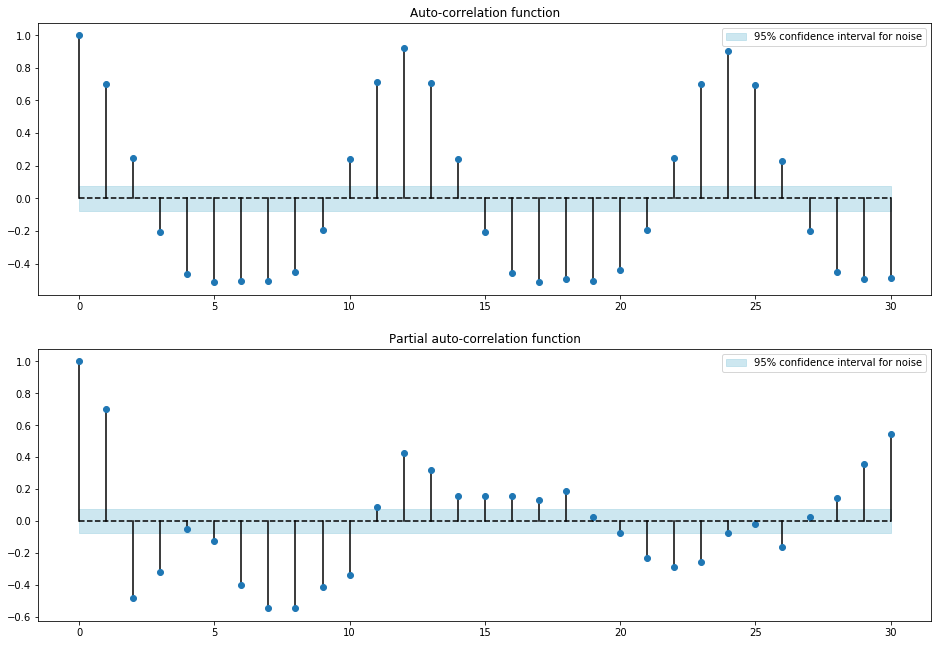

In [12]:
plot_cfs(co2_train[1:]-co2_train[:-1], nlags=30)

# Model estimation

## (0,1,0) (0,0,0)_12

In [73]:
order = (0,1,0)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=(0,0,0,12)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  718
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1168.165
Date:                Fri, 15 Nov 2019   AIC                           2338.330
Time:                        10:47:44   BIC                           2342.905
Sample:                             0   HQIC                          2340.096
                                - 718                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5229      0.128     11.895      0.000       1.272       1.774
===================================================================================
Ljung-Box (Q):                     7555.72   Jarque-Bera (JB):                69.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.58
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

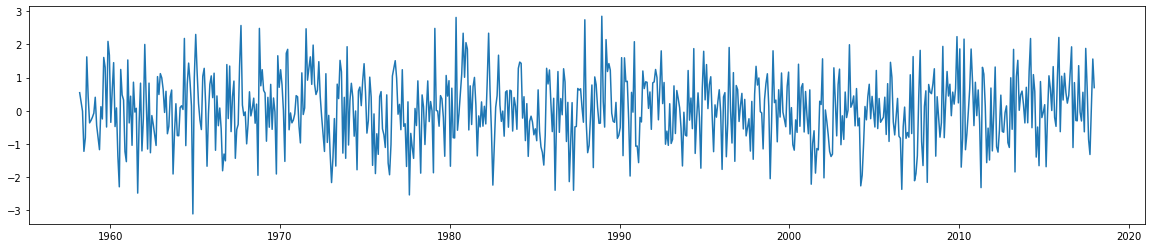

In [74]:
plt.figure(figsize=(20,4))
plt.plot(time_train, np.random.randn(time_train.size))

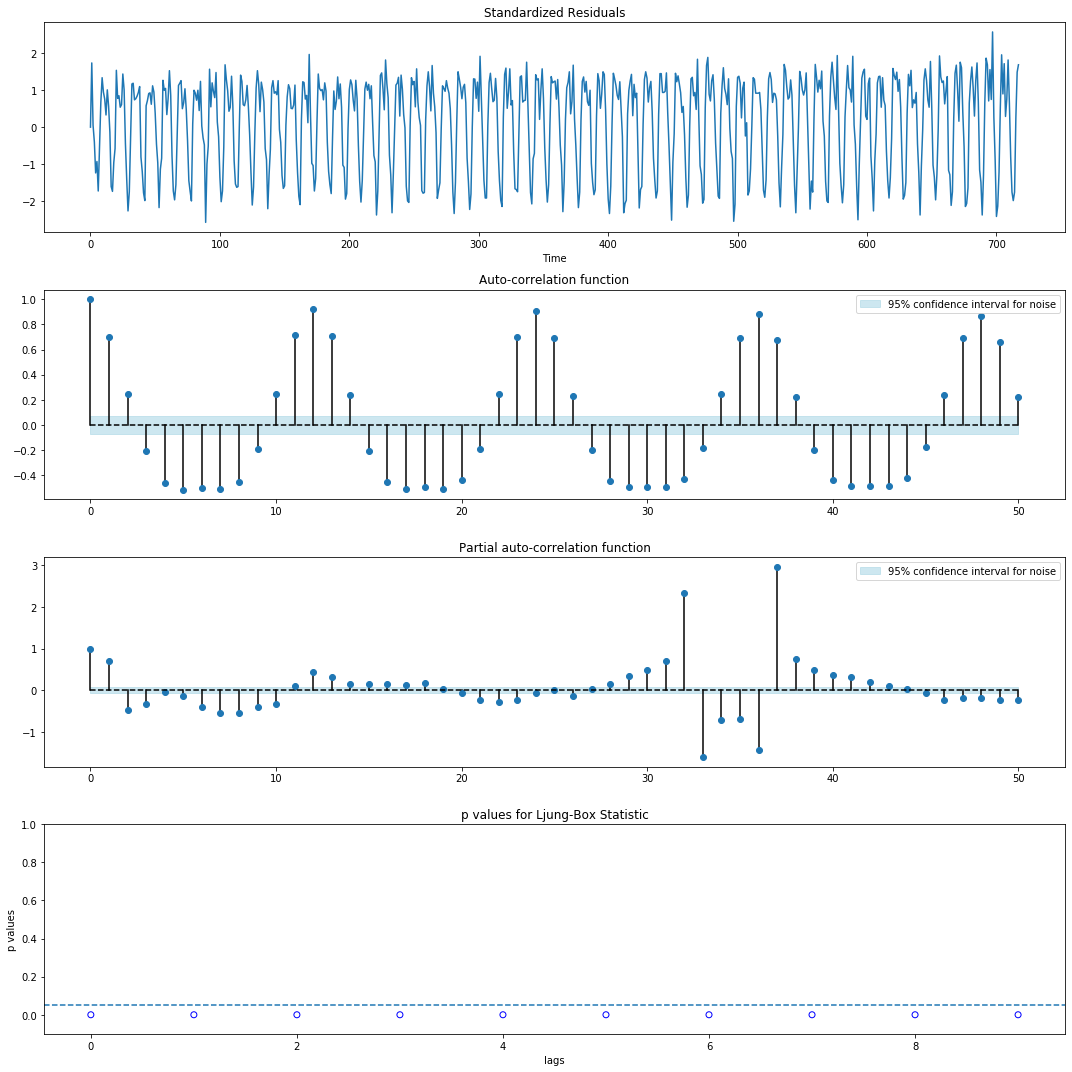

In [75]:
tsdiag(model.resid)

Ljung box test is not concluent same for sign test. Plus acf and pacf show values that cannot be 0 for lag greater than 1. 

In ACF seems to be significant value every 12 lags, meaning that there should be a seasonal part in the AR part as well. It can also be seen that residual seems to vary somewhat periodically every 12 steps. 

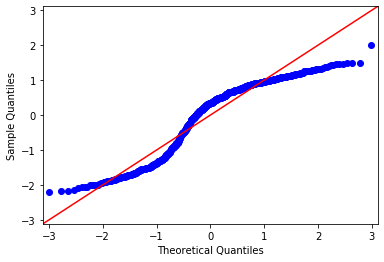

In [76]:
qqplot(model.resid)

### $H_0$: the residuals are normaly distributed

In [77]:
sign_test(model.resid)

(121, 3.18707697204173e-76)

$H_0$ is rejected

In [78]:
sign_test(np.random.randn(time_train.size))

(361, 0.8812650532500622)

$H_0$ cannot be rejected.

## (0,1,0) (0,0,1)_12

In [139]:
order = (0,1,0)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=(0,0,1,12)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(0, 1, 0)x(0, 0, 1, 12)   Log Likelihood                -876.887
Date:                            Fri, 15 Nov 2019   AIC                           1757.774
Time:                                    15:21:50   BIC                           1766.924
Sample:                                         0   HQIC                          1761.307
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.7436      0.029     25.300      0.000       0.686       0.801
sigma2         0.6667      0.046     14.620      0.000       0.577       0.756
===================================================================================
Ljung-Box (Q):                     4226.10   Jarque-Bera (JB):                23.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.34
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

First metrics (AIC and BIC and log likelyhood greater) are way better and all params are significant. 
This seems to be a good model let's make a deeper analysis.

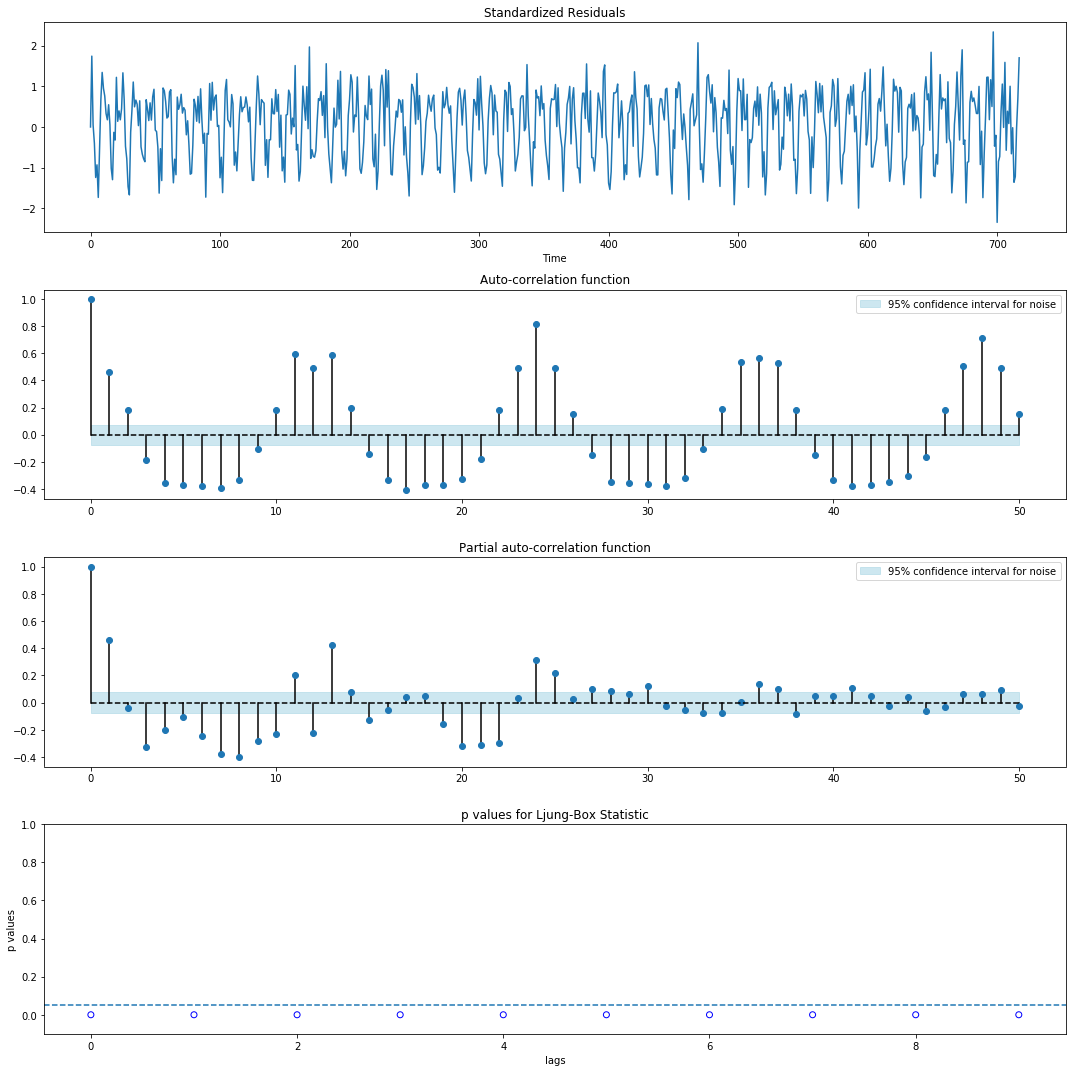

In [140]:
tsdiag(model.resid[:])

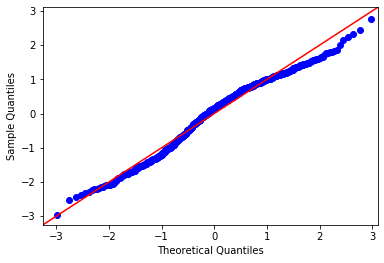

In [141]:
qqplot(model.resid[13:])

In [142]:
sign_test(model.resid)

(188, 2.182750052294067e-38)

Damped oscillation in PACF and ACF means that the AR and MA part are missing some order in our model. Plus Ljung Box is not satisfied

## (0,1,0)(1,0,1)_12

In [146]:
order = (0,1,0)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=(0,1,1,12)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -223.520
Date:                            Fri, 15 Nov 2019   AIC                            451.040
Time:                                    16:10:32   BIC                            460.156
Sample:                                         0   HQIC                           454.563
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9040      0.020    -44.676      0.000      -0.944      -0.864
sigma2         0.1072      0.005     20.078      0.000       0.097       0.118
===================================================================================
Ljung-Box (Q):                      113.87   Jarque-Bera (JB):                 4.41
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.14
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

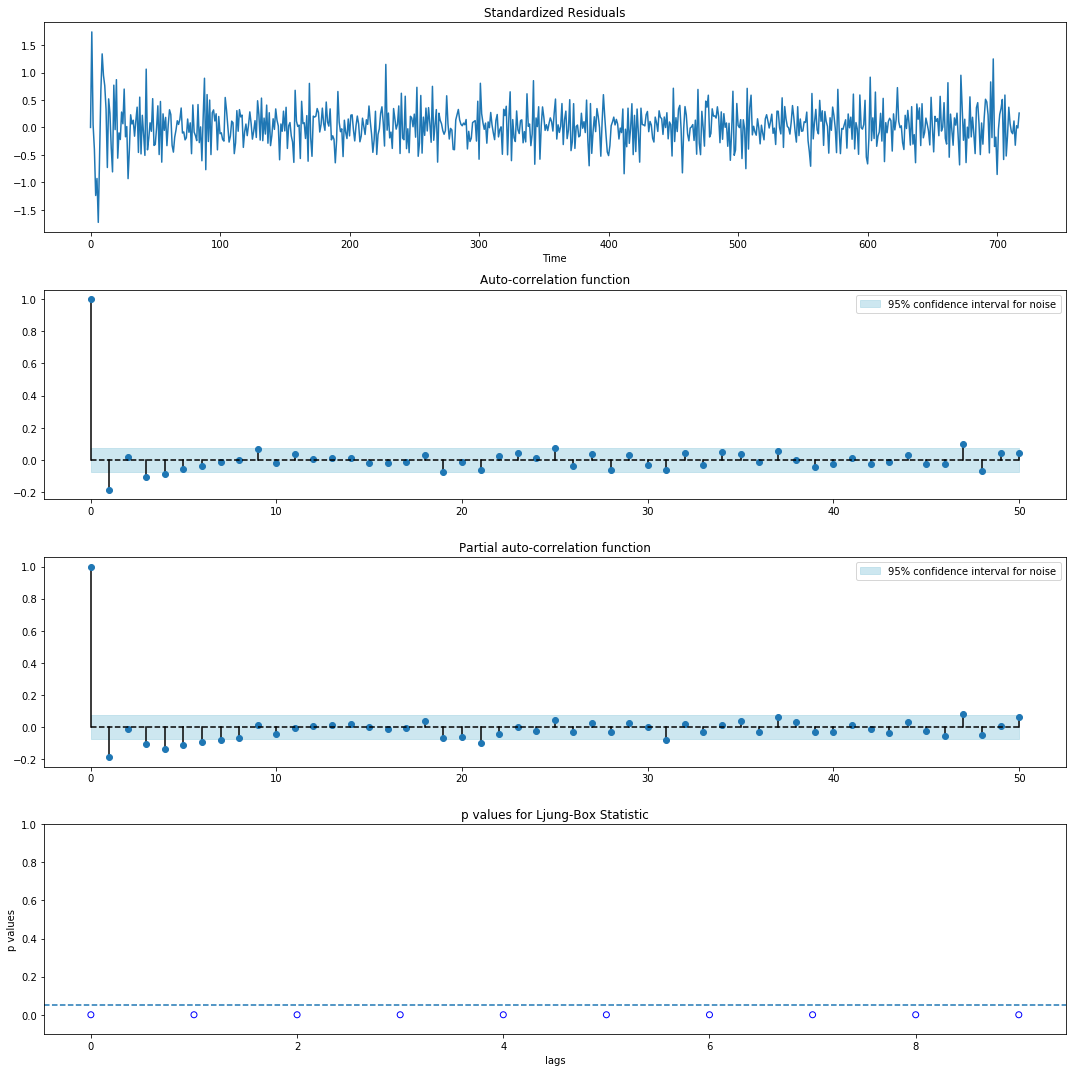

In [148]:
tsdiag(model.resid)

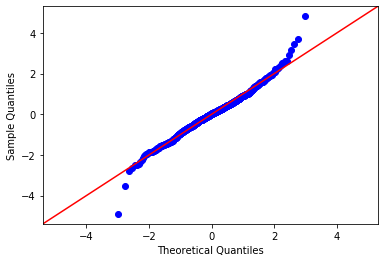

In [85]:
qqplot(model.resid)

In [147]:
sign_test(model.resid)

(420, 4.953498391340614e-06)

## (1,1,1) (1,0,0) 

In [108]:
order = (1,1,1)
seasonal_order = (1,0,0,12)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=seasonal_order).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 12)   Log Likelihood                -384.299
Date:                            Fri, 15 Nov 2019   AIC                            776.599
Time:                                    14:59:11   BIC                            794.899
Sample:                                         0   HQIC                           783.665
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2381      0.088      2.709      0.007       0.066       0.410
ma.L1         -0.5845      0.074     -7.938      0.000      -0.729      -0.440
ar.S.L12       0.9675      0.009    108.120      0.000       0.950       0.985
sigma2         0.1633      0.008     19.768      0.000       0.147       0.179
===================================================================================
Ljung-Box (Q):                      189.12   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.00   Prob(JB):                         0.23
Heteroskedasticity (H):               1.11   Skew:                             0.12
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

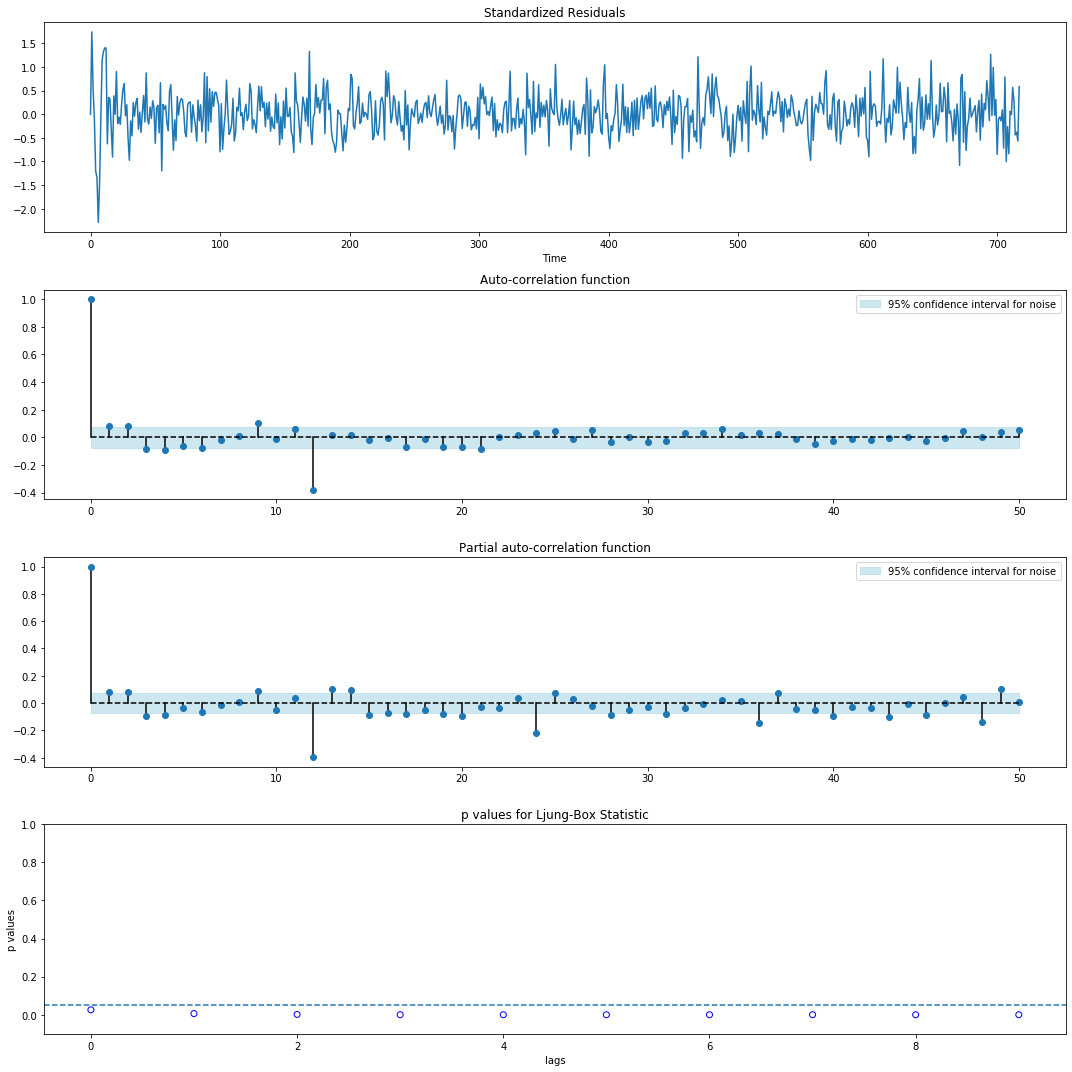

In [109]:
tsdiag(model.resid)

## (1,1,1) (1,1,0)

In [110]:
order = (1,1,1)
seasonal_order = (1,1,0,12)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=seasonal_order).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -272.797
Date:                            Fri, 15 Nov 2019   AIC                            553.594
Time:                                    15:00:09   BIC                            571.826
Sample:                                         0   HQIC                           560.639
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1475      0.085      1.743      0.081      -0.018       0.313
ma.L1         -0.5363      0.074     -7.250      0.000      -0.681      -0.391
ar.S.L12      -0.4949      0.032    -15.471      0.000      -0.558      -0.432
sigma2         0.1263      0.007     19.350      0.000       0.114       0.139
===================================================================================
Ljung-Box (Q):                      130.17   Jarque-Bera (JB):                 1.93
Prob(Q):                              0.00   Prob(JB):                         0.38
Heteroskedasticity (H):               1.04   Skew:                             0.11
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

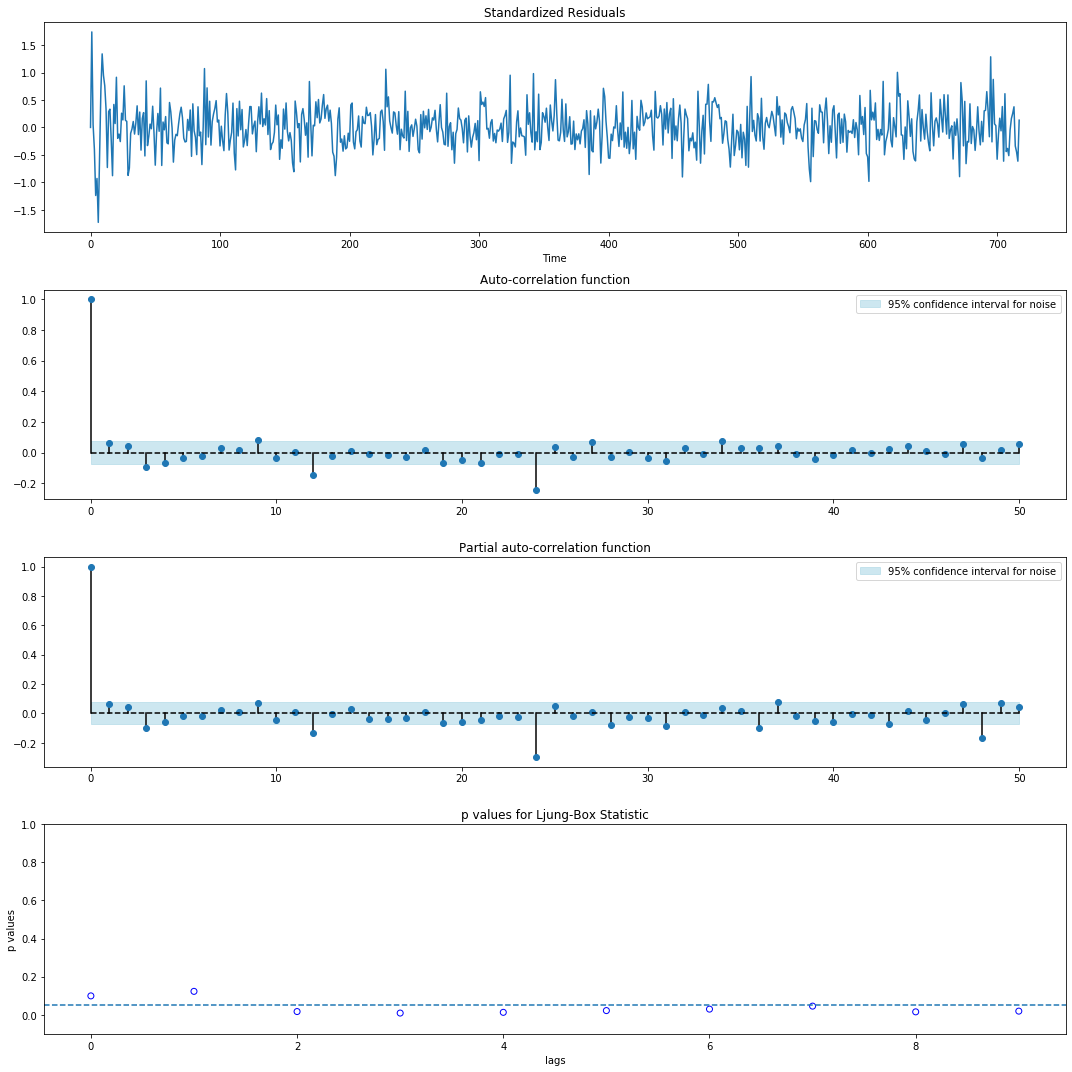

In [111]:
tsdiag(model.resid)

## (1,1,1) (1,0,1)_12

In [127]:
order = (1,1,1)
seasonal_order = (1,0,1,12)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=seasonal_order).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -202.873
Date:                            Fri, 15 Nov 2019   AIC                            415.746
Time:                                    15:06:24   BIC                            438.622
Sample:                                         0   HQIC                           424.579
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2328      0.067      3.488      0.000       0.102       0.364
ma.L1         -0.5796      0.057    -10.142      0.000      -0.692      -0.468
ar.S.L12       0.9996      0.000   3126.125      0.000       0.999       1.000
ma.S.L12      -0.8646      0.023    -38.153      0.000      -0.909      -0.820
sigma2         0.0954      0.005     20.480      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       49.78   Jarque-Bera (JB):                 5.07
Prob(Q):                              0.14   Prob(JB):                         0.08
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

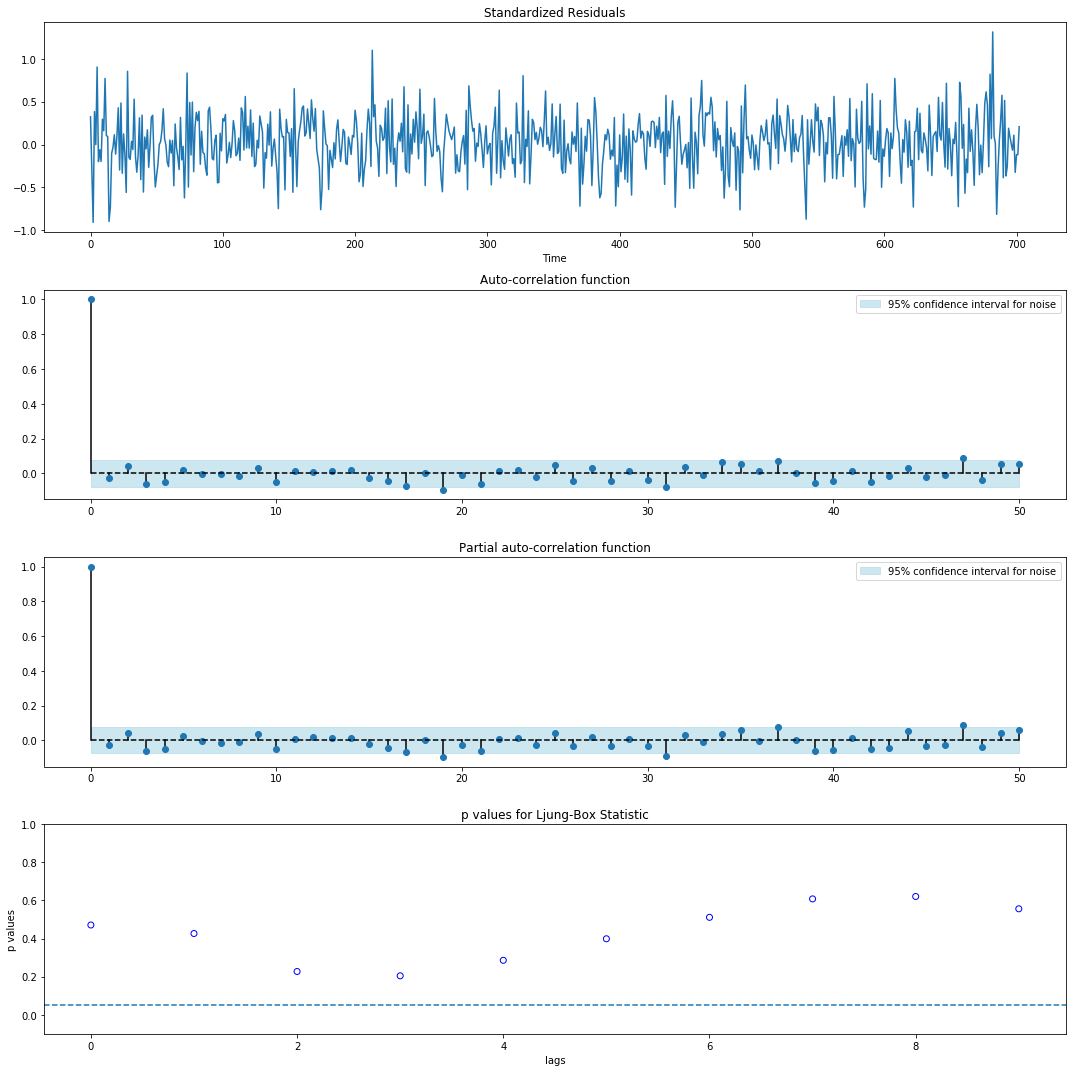

In [128]:
tsdiag(model.resid[15:])

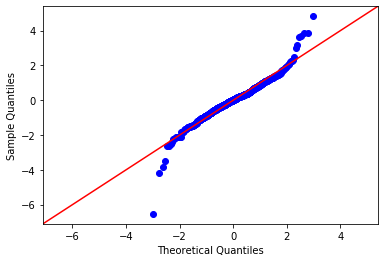

In [89]:
qqplot(model.resid)

In [90]:
sign_test(model.resid)

(362, 0.8227189278768448)

In [129]:
order = (1,1,1)
seasonal_order = (1,1,1,12)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=seasonal_order).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -180.266
Date:                            Fri, 15 Nov 2019   AIC                            370.532
Time:                                    15:07:29   BIC                            393.323
Sample:                                         0   HQIC                           379.339
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2007      0.082      2.447      0.014       0.040       0.362
ma.L1         -0.5641      0.071     -7.961      0.000      -0.703      -0.425
ar.S.L12      -0.0013      0.044     -0.029      0.977      -0.088       0.085
ma.S.L12      -0.8629      0.027    -31.509      0.000      -0.917      -0.809
sigma2         0.0954      0.005     20.399      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       43.32   Jarque-Bera (JB):                 5.03
Prob(Q):                              0.33   Prob(JB):                         0.08
Heteroskedasticity (H):               1.12   Skew:                             0.01
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

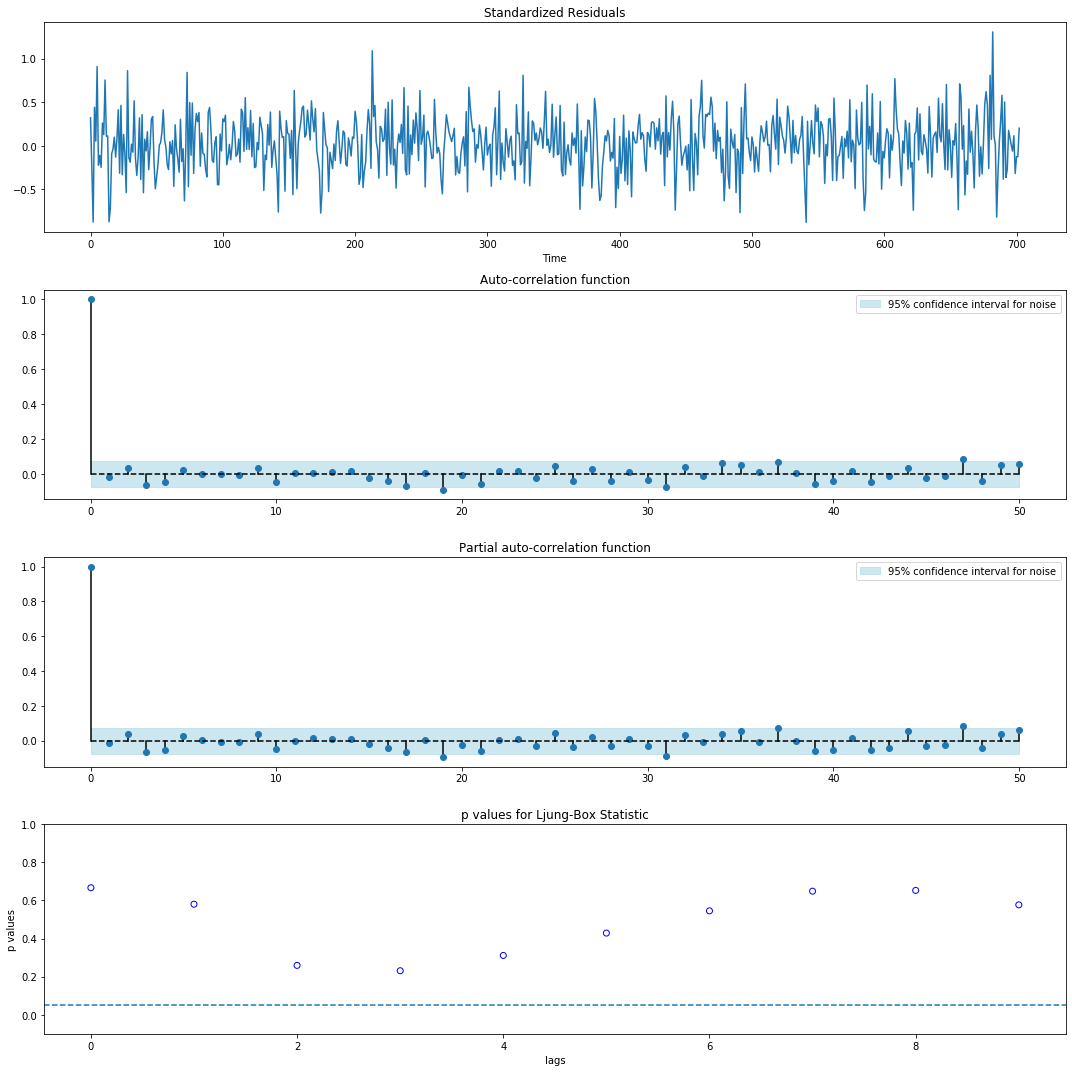

In [130]:
tsdiag(model.resid[15:])

## (1,1,1) (0,1,1)

In [36]:
order = (1,1,1)
seasonal_order = (0,1,1,12)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=seasonal_order).fit()
# model = smt.SARIMAX(co2_train,exog=time_train, order = order, seasonal_order=seasonal_order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -180.266
Date:                            Wed, 20 Nov 2019   AIC                            368.533
Time:                                    16:09:09   BIC                            386.766
Sample:                                         0   HQIC                           375.579
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2008      0.082      2.456      0.014       0.041       0.361
ma.L1         -0.5641      0.071     -7.975      0.000      -0.703      -0.425
ma.S.L12      -0.8632      0.022    -38.922      0.000      -0.907      -0.820
sigma2         0.0954      0.005     20.445      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       43.31   Jarque-Bera (JB):                 5.02
Prob(Q):                              0.33   Prob(JB):                         0.08
Heteroskedasticity (H):               1.12   Skew:                             0.01
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

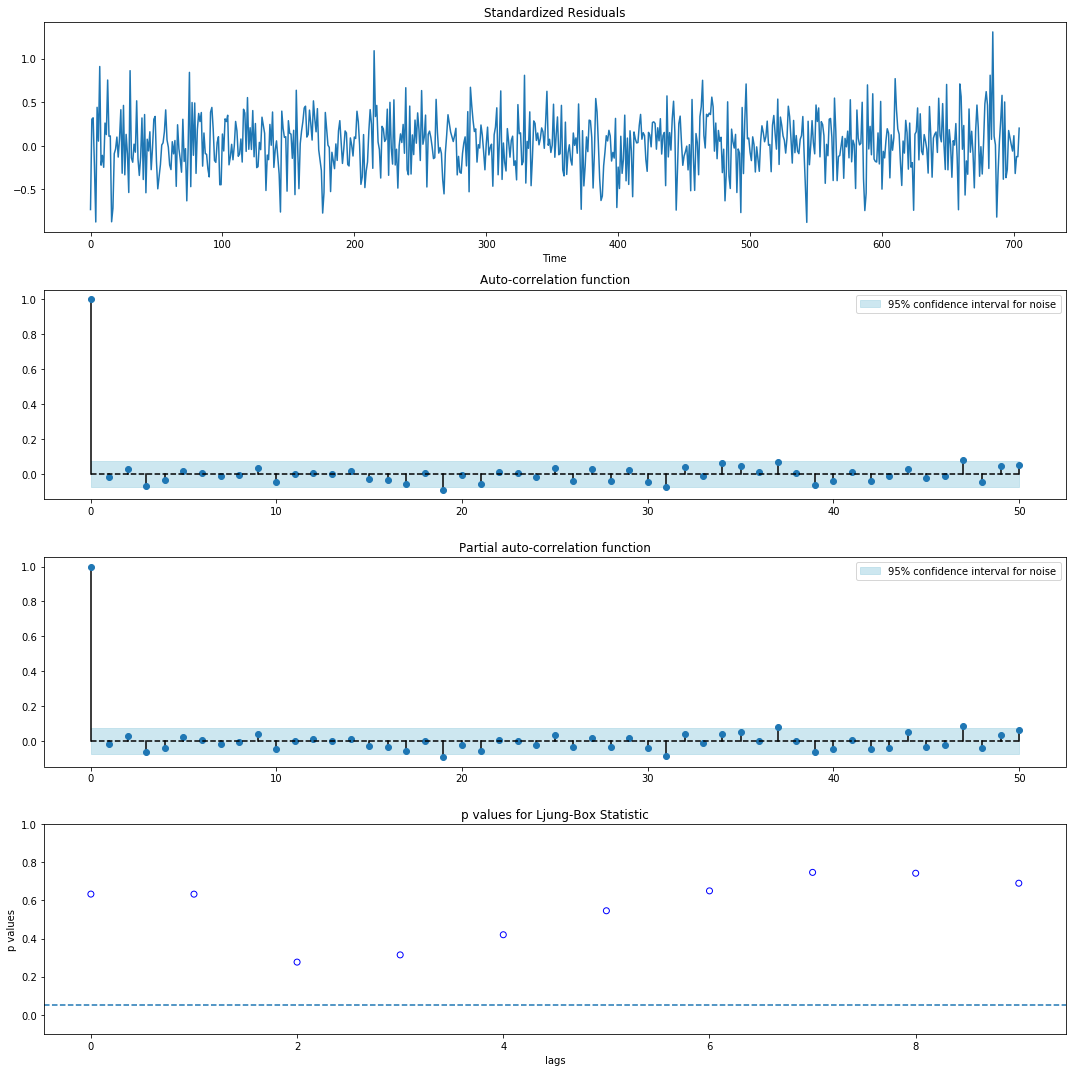

In [40]:
tsdiag(model.resid[13:])

In [38]:
sign_test(model.resid[15:])

(352, 0.9698965103844422)

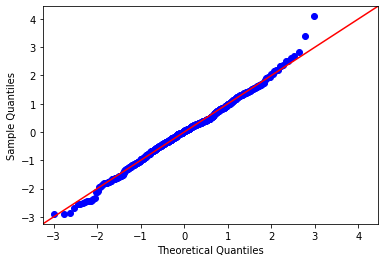

In [159]:
qqplot(model.resid[15:])

## (1,2,1) (0,1,1)

In [154]:
order = (1,2,1)
seasonal_order = (0,1,1,12)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=seasonal_order).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -194.061
Date:                            Fri, 15 Nov 2019   AIC                            396.122
Time:                                    16:49:32   BIC                            414.349
Sample:                                         0   HQIC                           403.166
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3073      0.034     -8.936      0.000      -0.375      -0.240
ma.L1         -0.9996      0.148     -6.740      0.000      -1.290      -0.709
ma.S.L12      -0.8803      0.022    -40.050      0.000      -0.923      -0.837
sigma2         0.0975      0.014      6.755      0.000       0.069       0.126
===================================================================================
Ljung-Box (Q):                       57.89   Jarque-Bera (JB):                 2.35
Prob(Q):                              0.03   Prob(JB):                         0.31
Heteroskedasticity (H):               1.13   Skew:                             0.01
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

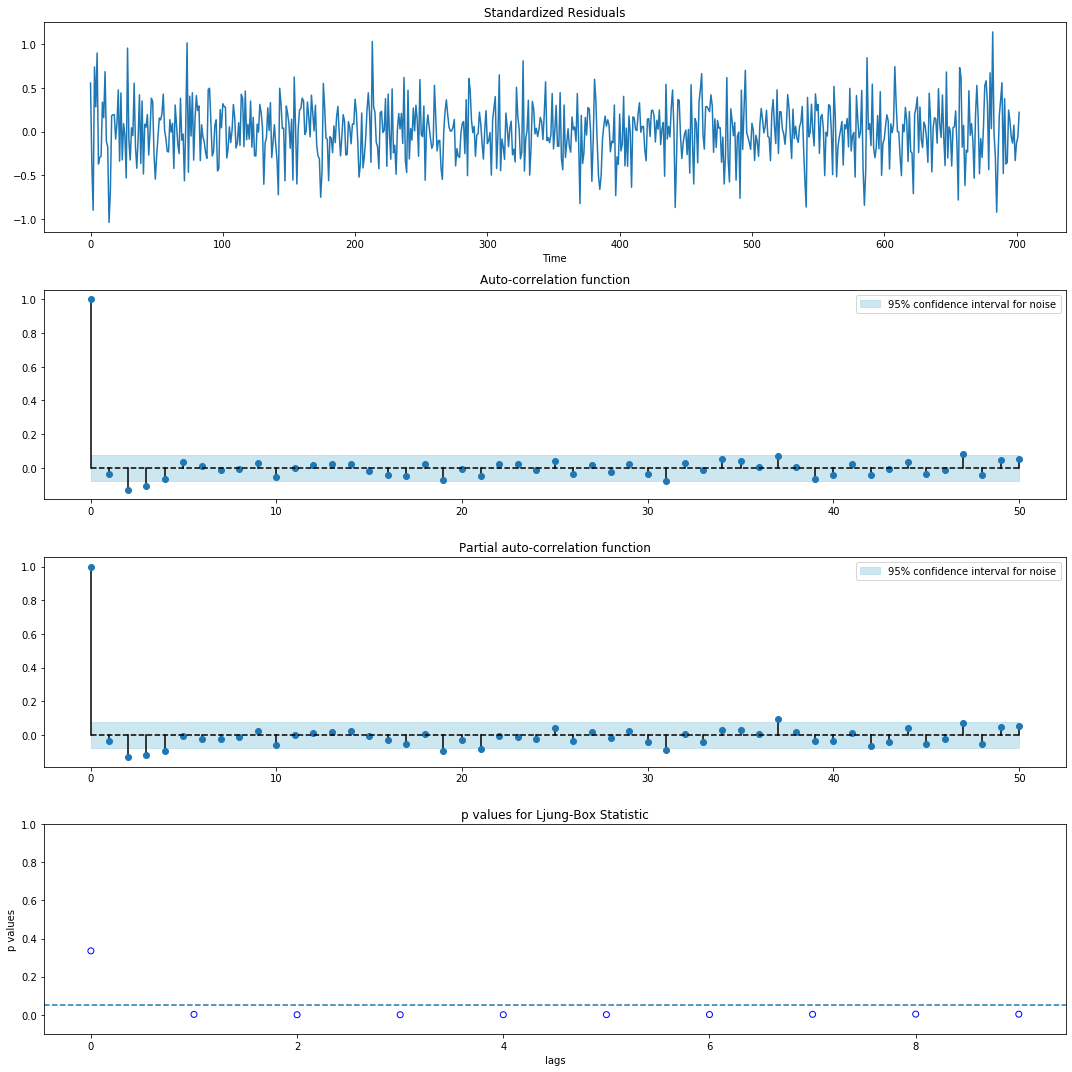

In [155]:
tsdiag(model.resid[15:])

In [121]:
order = (4,2,2)
seasonal_order = (0,1,1,12)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=seasonal_order).fit()

model.summary()

/home/pierre/miniconda3/envs/TSA/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(4, 2, 2)x(0, 1, 1, 12)   Log Likelihood                -181.410
Date:                            Fri, 15 Nov 2019   AIC                            378.819
Time:                                    15:04:33   BIC                            415.274
Sample:                                         0   HQIC                           392.907
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3045      0.340     -0.896      0.370      -0.970       0.361
ar.L2         -0.1399      0.125     -1.122      0.262      -0.384       0.105
ar.L3         -0.1481      0.064     -2.324      0.020      -0.273      -0.023
ar.L4         -0.1088      0.056     -1.955      0.051      -0.218       0.000
ma.L1         -1.0565      0.337     -3.139      0.002      -1.716      -0.397
ma.L2          0.0582      0.342      0.170      0.865      -0.613       0.729
ma.S.L12      -0.8844      0.021    -42.780      0.000      -0.925      -0.844
sigma2         0.0938      0.005     18.762      0.000       0.084       0.104
===================================================================================
Ljung-Box (Q):                       45.45   Jarque-Bera (JB):                 5.05
Prob(Q):                              0.26   Prob(JB):                         0.08
Heteroskedasticity (H):               1.13   Skew:                             0.03
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

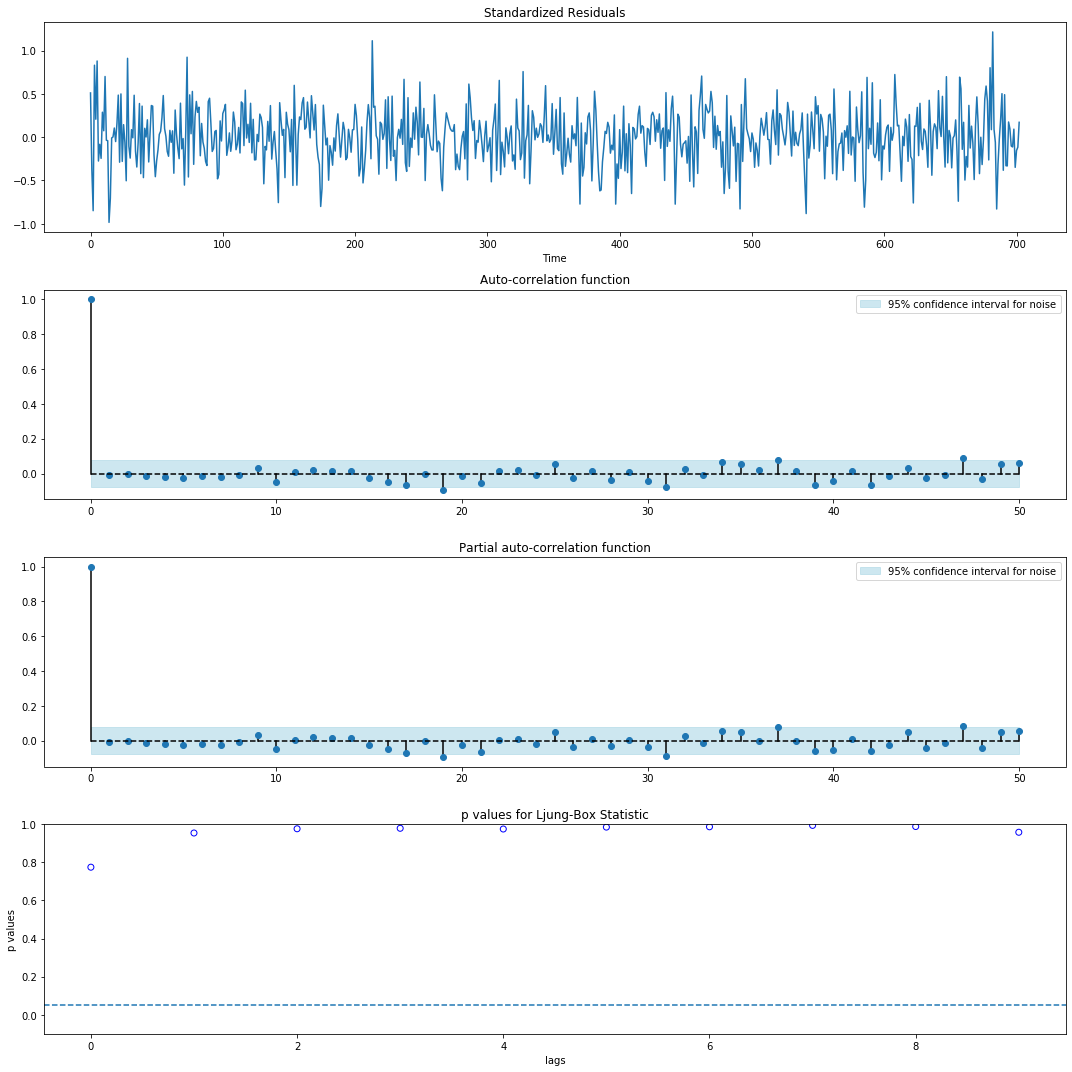

In [124]:
tsdiag(model.resid[15:])

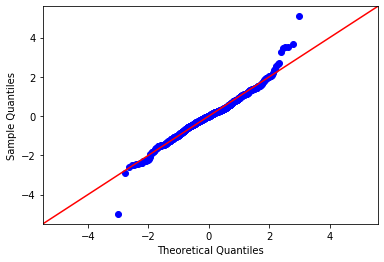

In [123]:
qqplot(model.resid)

In [31]:
sign_test(model.resid)

(360, 0.9404671576181338)

In [45]:
order = (2,1,1)
seasonal_order = (0,1,1,12)
# model = smt.ARIMA(co2_train, order = order).fit()
model = smt.SARIMAX(co2_train-co2_train[0], order = order, seasonal_order=seasonal_order).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -179.585
Date:                            Fri, 15 Nov 2019   AIC                            369.170
Time:                                    08:21:31   BIC                            391.961
Sample:                                         0   HQIC                           377.977
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2932      0.127      2.314      0.021       0.045       0.542
ar.L2          0.0681      0.069      0.983      0.326      -0.068       0.204
ma.L1         -0.6625      0.124     -5.348      0.000      -0.905      -0.420
ma.S.L12      -0.8641      0.022    -38.959      0.000      -0.908      -0.821
sigma2         0.0952      0.005     20.408      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       40.11   Jarque-Bera (JB):                 4.77
Prob(Q):                              0.47   Prob(JB):                         0.09
Heteroskedasticity (H):               1.13   Skew:                             0.01
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

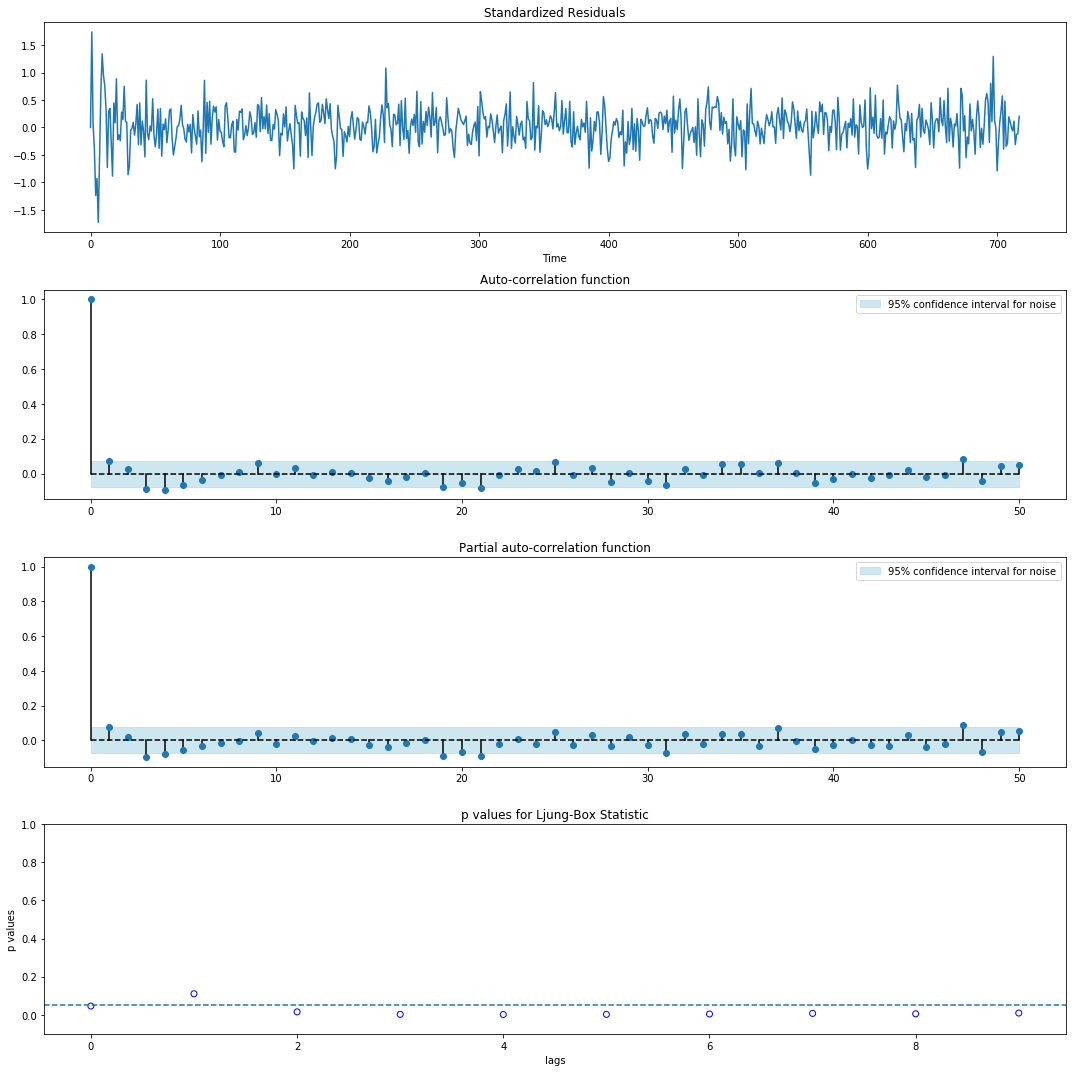

In [46]:
tsdiag(model.resid)

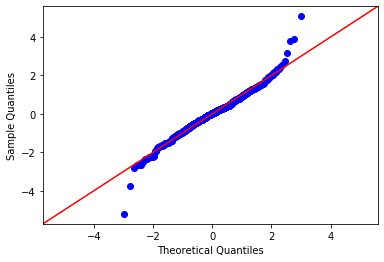

In [43]:
qqplot(model.resid[:])

In [45]:
sign_test(model.resid)

(362, 0.8227189278768448)

In [53]:
auto_model = auto_arima(co2_train, 
                           start_p=0, max_p=5, 
                           start_q=0, max_q=5,
                           start_d=0, max_d=2, 
                           start_P=0, max_P=2,
                           start_Q=0, max_Q=2,
                           D=1,
                           max_order=20, 
                           seasonal=True, m=12,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=834.398, BIC=843.514, Fit time=0.187 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=574.623, BIC=592.856, Fit time=0.981 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=367.356, BIC=385.589, Fit time=1.263 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=369.356, BIC=392.147, Fit time=2.700 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=743.854, BIC=757.529, Fit time=0.178 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=369.356, BIC=392.147, Fit time=5.778 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=370.885, BIC=398.234, Fit time=15.794 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=363.569, BIC=386.360, Fit time=2.606 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=384.556, BIC=402.789, Fit time=1.320 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0,

In [47]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  718
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.724
Date:                            Wed, 13 Nov 2019   AIC                            427.448
Time:                                    17:46:02   BIC                            464.049
Sample:                                         0   HQIC                           441.581
                                            - 718                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.875      0.382      -0.000       0.001
ar.L1          0.1803      0.172      1.049      0.294      -0.157       0.517
ar.L2          0.0382      0.076      0.503      0.615      -0.111       0.187
ar.L3         -0.0821      0.047     -1.744      0.081      -0.174       0.010
ma.L1         -0.5365      0.173     -3.099      0.002      -0.876      -0.197
ar.S.L12       0.9986      0.001   1227.683      0.000       0.997       1.000
ma.S.L12      -0.8235      0.028    -29.443      0.000      -0.878      -0.769
sigma2         0.0991      0.005     19.342      0.000       0.089       0.109
===================================================================================
Ljung-Box (Q):                       47.12   Jarque-Bera (JB):                 3.04
Prob(Q):                              0.20   Prob(JB):                         0.22
Heteroskedasticity (H):               1.08   Skew:                             0.02
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# TSDIAG on noise for comparison

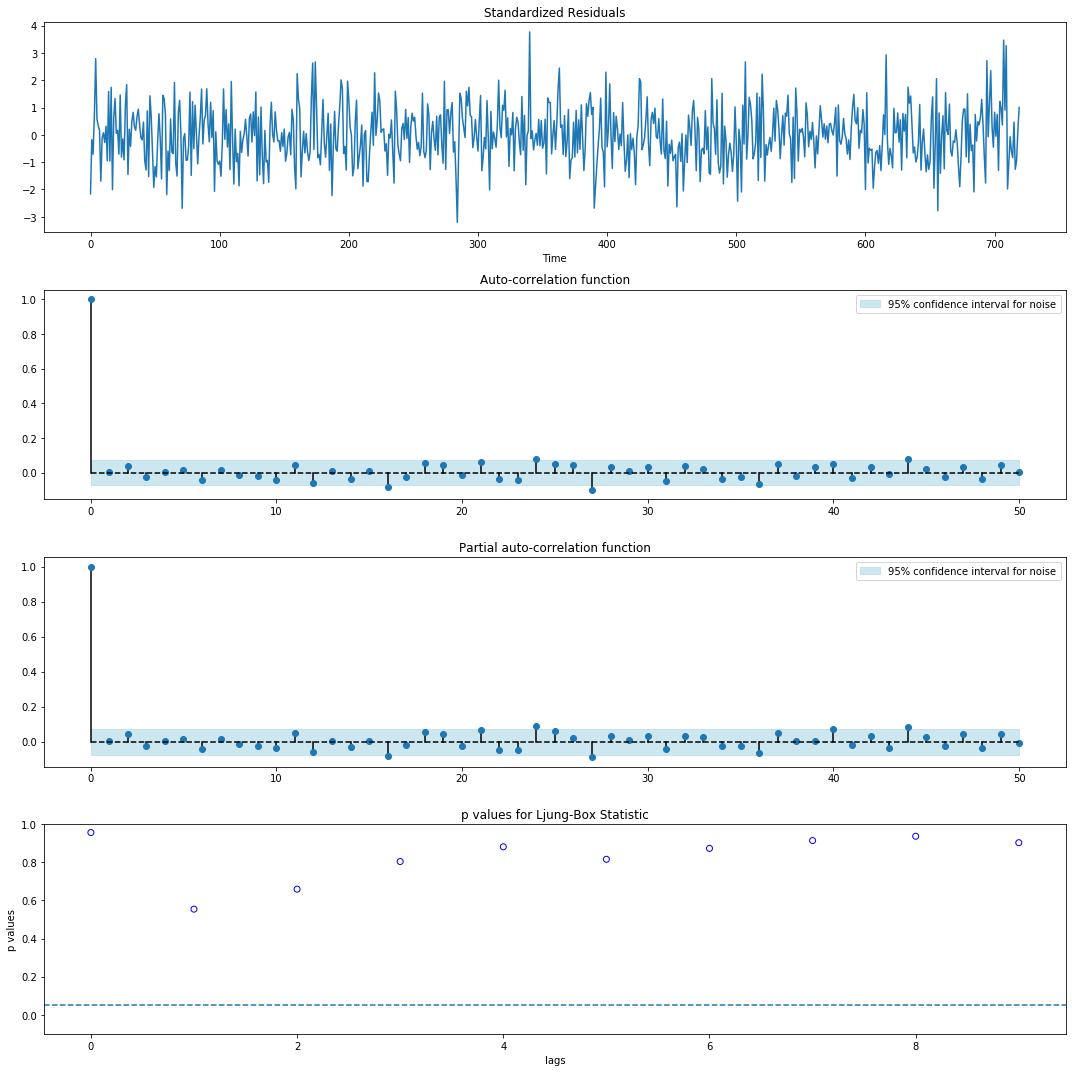

In [72]:
tsdiag(np.random.randn(720))

# Predictions

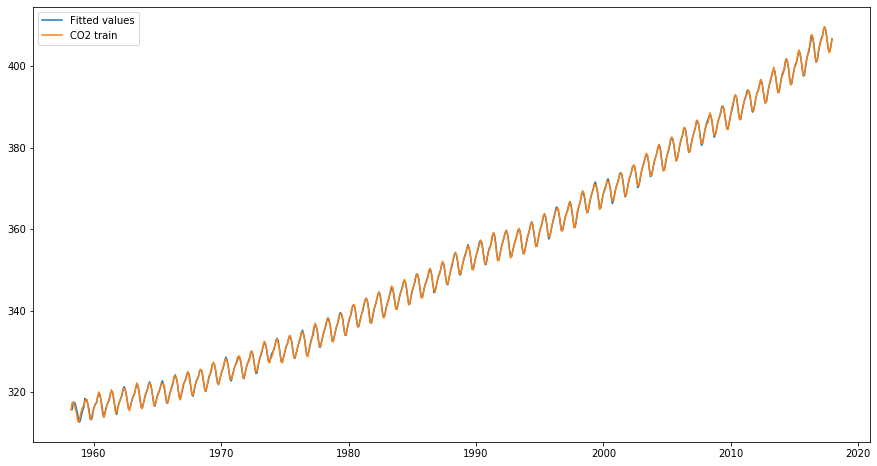

In [160]:
plt.figure(figsize=(15,8))
plt.plot(time_train, co2_train[0]+model.fittedvalues)
plt.plot(time_train, co2_train)
plt.legend(['Fitted values','CO2 train'])

In [161]:
predictions = model.get_forecast(48, alpha= 0.05).predicted_mean + co2_train[0]
conf_int = model.get_forecast(48, alpha= 0.05).conf_int() + co2_train[0]

time_pred = time_test[0] + np.array([t/12 for t in range(48)])

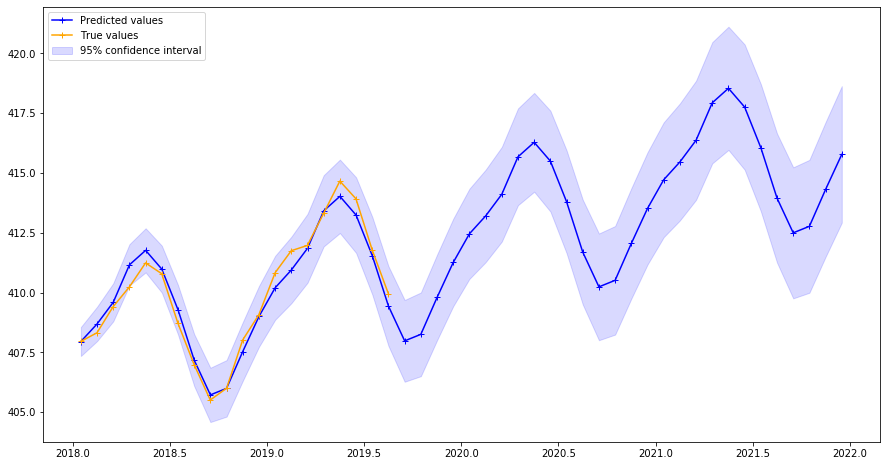

In [164]:
plt.figure(figsize=(15,8))
plt.plot(time_pred, predictions, color='blue', marker='+')
plt.fill_between(time_pred, conf_int[:,0], conf_int[:,1],color='blue', alpha=0.15)
plt.plot(time_test, co2_test, color='orange', marker='+')
plt.legend(['Predicted values', 'True values', '95% confidence interval'], loc=2)
plt.show()

In [165]:
indices = np.array([1,2,6,12,20]) -1 

In [166]:
predictions[indices]

array([407.95437515, 408.68844247, 410.9802319 , 409.00121486,
       409.43430097])

In [167]:
np.stack([predictions[indices], conf_int[:,0][indices], conf_int[:,1][indices]], axis=1)

array([[407.95437515, 407.3491151 , 408.55963521],
       [408.68844247, 407.97091003, 409.40597491],
       [410.9802319 , 410.00041122, 411.96005259],
       [409.00121486, 407.73080698, 410.27162273],
       [409.43430097, 407.7677407 , 411.10086123]])

In [168]:
res = pd.DataFrame(np.stack([predictions[indices], conf_int[:,0][indices], conf_int[:,1][indices]], axis=1))
res.columns = ['Predicted value', 'Lower bound', 'Upper bound']
res.index = indices+1

In [169]:
res

,Predicted value,Lower bound,Upper bound
1,407.954375,407.349115,408.559635
2,408.688442,407.970910,409.405975
6,410.980232,410.000411,411.960053
12,409.001215,407.730807,410.271623
20,409.434301,407.767741,411.100861


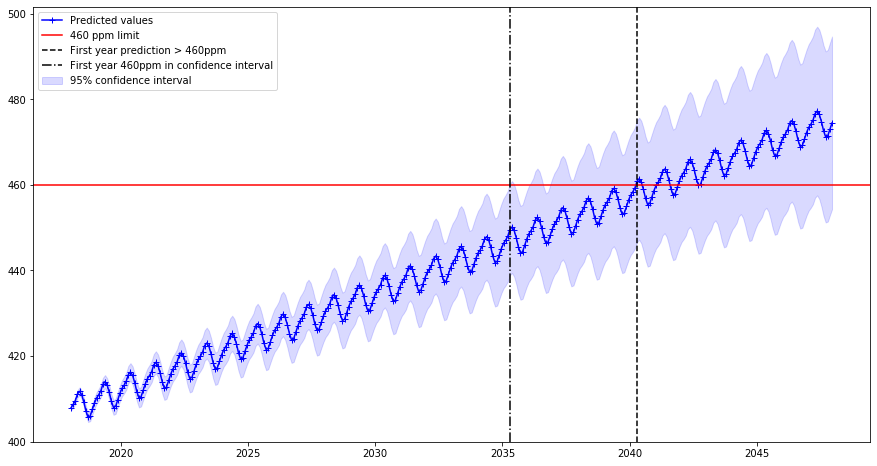

In [182]:
years_ahead = 30
predictions = model.get_forecast(years_ahead*12, alpha= 0.05).predicted_mean + co2_train[0]
conf_int = model.get_forecast(years_ahead*12, alpha= 0.05).conf_int() + co2_train[0]

time_pred = time_test[0] + np.array([t/12 for t in range(years_ahead*12)])

plt.figure(figsize=(15,8))
plt.plot(time_pred, predictions, color='blue', marker='+')
plt.fill_between(time_pred, conf_int[:,0], conf_int[:,1],color='blue', alpha=0.15)
plt.axhline(460, color='r')
plt.axvline(2040.29, color='k', linestyle='--')
plt.axvline(2035.29, color='k', linestyle='-.')
# plt.plot(time_test, co2_test, color='orange', marker='+')
plt.legend(['Predicted values', '460 ppm limit', 'First year prediction > 460ppm', 'First year 460ppm in confidence interval','95% confidence interval'], loc=2)
plt.show()

In [174]:
idx = np.where(predictions>=460)[0][0]
print(time_pred[idx])

2040.2920000000001


In [175]:
idx = np.where(conf_int[:,1]>=460)[0][0]
print(time_pred[idx])

2035.2920000000001
